# Multimodal vs. Tabular Comparison Pipeline
## Measuring the Value of "Curb Appeal"

This notebook trains two models to quantify the improvement gained from satellite imagery:
1. **Tabular Baseline:** Predicts price using only CSV features (Bedrooms, Sqft, etc.).
2. **Multimodal Model:** Predicts price using CSV features + Satellite Images (Gated Fusion).

**Goal:** Show that Model 2 achieves a lower RMSE than Model 1.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import r2_score

# CONFIGURATION
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "processed_data"
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 20

print(f"Using Device: {DEVICE}")

Using Device: cuda


### 1. Dataset Class
Standard loader for our processed data.

In [2]:
class RealEstateDataset(Dataset):
    def __init__(self, x_path, y_path, meta_path, transform=None):
        self.X = pd.read_csv(x_path).values.astype(np.float32)
        self.y = pd.read_csv(y_path).values.astype(np.float32)
        self.meta = pd.read_csv(meta_path)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        tabular = torch.tensor(self.X[idx])
        price = torch.tensor(self.y[idx])
        img_path = self.meta.iloc[idx]['image_path']
        
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except:
            image = torch.zeros((3, 224, 224))
        return image, tabular, price

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = RealEstateDataset(
    f"{DATA_DIR}/X_train.csv", f"{DATA_DIR}/y_train.csv", f"{DATA_DIR}/meta_train.csv", transform=transform
)

train_size = int(0.8 * len(full_dataset))
train_ds, val_ds = torch.utils.data.random_split(full_dataset, [train_size, len(full_dataset)-train_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

### 2. Define Both Models
1. **TabularNet:** Simple MLP (The Baseline).
2. **MultimodalNet:** Gated Fusion (The Challenger).

In [3]:
# --- MODEL 1: TABULAR ONLY ---
class TabularNet(nn.Module):
    def __init__(self, input_dim):
        super(TabularNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, image, tabular):
        # NOTE: We accept 'image' to keep the training loop simple, 
        # but we purposefully ignore it here.
        return self.net(tabular)

# --- MODEL 2: MULTIMODAL (GATED FUSION) ---
class MultimodalNet(nn.Module):
    def __init__(self, tabular_input_dim):
        super(MultimodalNet, self).__init__()
        # Visual
        resnet = models.resnet18(pretrained=True)
        self.image_extractor = nn.Sequential(*list(resnet.children())[:-1])
        # Freeze early layers
        for param in list(self.image_extractor.parameters())[:6]:
            param.requires_grad = False
            
        # Tabular
        self.tabular_extractor = nn.Sequential(
            nn.Linear(tabular_input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        # Gate
        self.gate = nn.Sequential(
            nn.Linear(512 + 64, 32), nn.ReLU(),
            nn.Linear(32, 1), nn.Sigmoid()
        )
        # Head
        self.regressor = nn.Sequential(
            nn.Linear(512 + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, image, tabular):
        img_feat = self.image_extractor(image).flatten(1)
        tab_feat = self.tabular_extractor(tabular)
        z = self.gate(torch.cat((img_feat, tab_feat), dim=1))
        weighted_img = img_feat * z
        return self.regressor(torch.cat((weighted_img, tab_feat), dim=1))

### 3. Unified Training Function
A single function to train any model we pass to it.

In [4]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def train_model(model, name="Model"):
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    history = {'train_loss': [], 'val_loss': [], 'val_rmse': [], 'val_r2': []}
    best_loss = float('inf')
    
    print(f"\n--- Training {name} ---")
    
    for epoch in range(EPOCHS):
        # --- Training ---
        model.train()
        train_loss = 0.0
        for imgs, tabs, tgts in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            imgs, tabs, tgts = imgs.to(DEVICE), tabs.to(DEVICE), tgts.to(DEVICE)
            optimizer.zero_grad()
            out = model(imgs, tabs)
            loss = criterion(out.squeeze(), tgts.squeeze())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item() * imgs.size(0)
            
        avg_train_loss = train_loss / len(train_ds)

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        all_preds, all_tgts = [], []
        
        with torch.no_grad():
            for imgs, tabs, tgts in val_loader:
                imgs, tabs, tgts = imgs.to(DEVICE), tabs.to(DEVICE), tgts.to(DEVICE)
                out = model(imgs, tabs)
                val_loss += criterion(out.squeeze(), tgts.squeeze()).item() * imgs.size(0)
                all_preds.append(out.squeeze().cpu().numpy())
                all_tgts.append(tgts.squeeze().cpu().numpy())

        avg_val_loss = val_loss / len(val_ds)
        rmse = np.sqrt(avg_val_loss)
        r2 = r2_score(np.concatenate(all_tgts), np.concatenate(all_preds))
        scheduler.step(avg_val_loss)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_rmse'].append(rmse)
        history['val_r2'].append(r2)

        # Save best
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), f"{name}_best.pth")

        print(f"Epoch {epoch+1} | Train MSE: {avg_train_loss:.4f} | Val MSE: {avg_val_loss:.4f} | R²: {r2:.4f}")
        
    return history


### 4. Run Comparisons

In [5]:
input_dim = full_dataset.X.shape[1]

# 1. Train Tabular Baseline
tabular_model = TabularNet(input_dim)
tab_history = train_model(tabular_model, name="Tabular_Baseline")

# 2. Train Multimodal Model
multi_model = MultimodalNet(input_dim)
multi_history = train_model(multi_model, name="Multimodal_Gated")


--- Training Tabular_Baseline ---


Epoch 1 | Train MSE: 411746669766.1349 | Val MSE: 444552479710.5194 | R²: -2.0338


Epoch 2 | Train MSE: 409514689627.6838 | Val MSE: 440336065901.7594 | R²: -2.0050


Epoch 3 | Train MSE: 403548956905.2765 | Val MSE: 431444333077.1622 | R²: -1.9444


Epoch 4 | Train MSE: 392670834187.3322 | Val MSE: 417898778277.8235 | R²: -1.8519


Epoch 5 | Train MSE: 376503986421.9116 | Val MSE: 398029360350.9932 | R²: -1.7163


Epoch 6 | Train MSE: 353758381381.4341 | Val MSE: 364305530243.2375 | R²: -1.4862


Epoch 7 | Train MSE: 325185822317.5704 | Val MSE: 328886806365.0191 | R²: -1.2445


Epoch 8 | Train MSE: 289387370251.3519 | Val MSE: 297318483941.4682 | R²: -1.0290


Epoch 9 | Train MSE: 247842445172.2236 | Val MSE: 245298467591.7384 | R²: -0.6740


Epoch 10 | Train MSE: 204024561189.5501 | Val MSE: 193829310193.6286 | R²: -0.3228


Epoch 11 | Train MSE: 159503571327.0030 | Val MSE: 138547933702.0012 | R²: 0.0545


Epoch 12 | Train MSE: 120207373596.6857 | Val MSE: 116449950424.9920 | R²: 0.2053


Epoch 13 | Train MSE: 88969000649.3332 | Val MSE: 77369159164.5256 | R²: 0.4720


Epoch 14 | Train MSE: 68318883849.4764 | Val MSE: 59844969491.5830 | R²: 0.5916


Epoch 15 | Train MSE: 58360560950.7457 | Val MSE: 51339509648.8192 | R²: 0.6496


Epoch 16 | Train MSE: 54919499138.2408 | Val MSE: 53224428291.9482 | R²: 0.6368


Epoch 17 | Train MSE: 52176233661.6062 | Val MSE: 57523126518.3664 | R²: 0.6074


Epoch 18 | Train MSE: 49137600161.2166 | Val MSE: 46286392714.8180 | R²: 0.6841


Epoch 19 | Train MSE: 48133832613.6587 | Val MSE: 43875045580.6737 | R²: 0.7006


Epoch 20 | Train MSE: 46666130487.6736 | Val MSE: 43181089234.2011 | R²: 0.7053


C:\Users\singh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\singh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Training Multimodal_Gated ---


Epoch 1 | Train MSE: 255672797295.3473 | Val MSE: 59850083166.9143 | R²: 0.5916


Epoch 2 | Train MSE: 46921032940.7511 | Val MSE: 33704058127.0031 | R²: 0.7700


Epoch 3 | Train MSE: 36601274673.4548 | Val MSE: 28704006904.8933 | R²: 0.8041


Epoch 4 | Train MSE: 33434524079.9642 | Val MSE: 27770377792.1184 | R²: 0.8105


Epoch 5 | Train MSE: 32383809351.6847 | Val MSE: 25887697008.1283 | R²: 0.8233


Epoch 6 | Train MSE: 30416043038.4033 | Val MSE: 24437472754.7341 | R²: 0.8332


Epoch 7 | Train MSE: 28470178882.1766 | Val MSE: 23271936844.9105 | R²: 0.8412


Epoch 8 | Train MSE: 28828265320.1413 | Val MSE: 22412796675.0006 | R²: 0.8470


Epoch 9 | Train MSE: 27494622203.6567 | Val MSE: 28592296014.9636 | R²: 0.8049


Epoch 10 | Train MSE: 27476665882.0205 | Val MSE: 19844035250.1419 | R²: 0.8646


Epoch 11 | Train MSE: 25144741817.5590 | Val MSE: 21344051076.1851 | R²: 0.8543


Epoch 12 | Train MSE: 25031186956.8326 | Val MSE: 34177332565.7545 | R²: 0.7668


Epoch 13 | Train MSE: 22920549195.3963 | Val MSE: 21528845752.9328 | R²: 0.8531


Epoch 14 | Train MSE: 21607334807.9179 | Val MSE: 24482650767.7138 | R²: 0.8329


Epoch 15 | Train MSE: 20340634280.5608 | Val MSE: 20063228208.4837 | R²: 0.8631


Epoch 16 | Train MSE: 19572833197.9505 | Val MSE: 20465722444.1209 | R²: 0.8603


Epoch 17 | Train MSE: 18329084604.8560 | Val MSE: 19934939437.3251 | R²: 0.8640


Epoch 18 | Train MSE: 17595329588.9097 | Val MSE: 19563862323.0105 | R²: 0.8665


Epoch 19 | Train MSE: 18199252101.2219 | Val MSE: 19407351759.3584 | R²: 0.8676


Epoch 20 | Train MSE: 16013751638.8864 | Val MSE: 21161516150.7613 | R²: 0.8556


In [10]:
print(f"Tabular Baseline Best R² : {max(tab_history['val_r2']):.4f}")
print(f"Multimodal Model Best R²  : {max(multi_history['val_r2']):.4f}")


Tabular Baseline Best R² : 0.7053
Multimodal Model Best R²  : 0.8676


### 5. Plot Results (The Verdict)
If the Orange Line (Multimodal) is lower than the Blue Line (Tabular), the images added value.

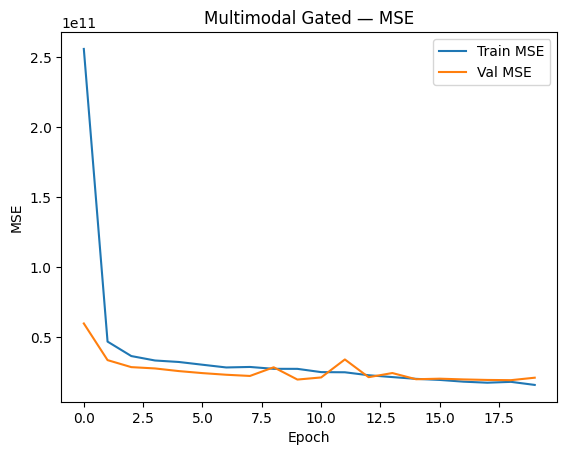

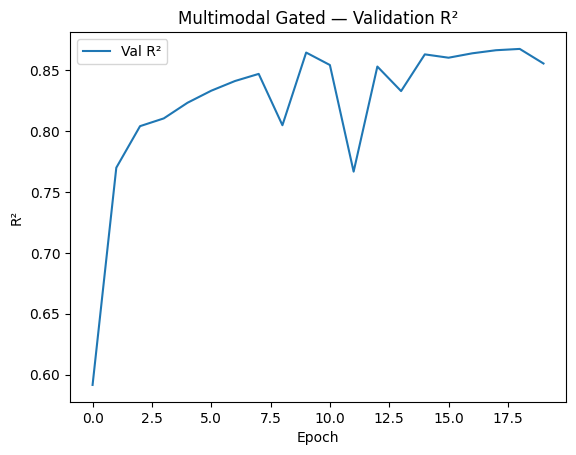

In [6]:
def plot_training_curves(history, name):
    plt.figure()
    plt.plot(history['train_loss'], label='Train MSE')
    plt.plot(history['val_loss'], label='Val MSE')
    plt.title(f'{name} — MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history['val_r2'], label='Val R²')
    plt.title(f'{name} — Validation R²')
    plt.xlabel('Epoch')
    plt.ylabel('R²')
    plt.legend()
    plt.show()

# plot_training_curves(tab_history, "Tabular Baseline")
plot_training_curves(multi_history, "Multimodal Gated")


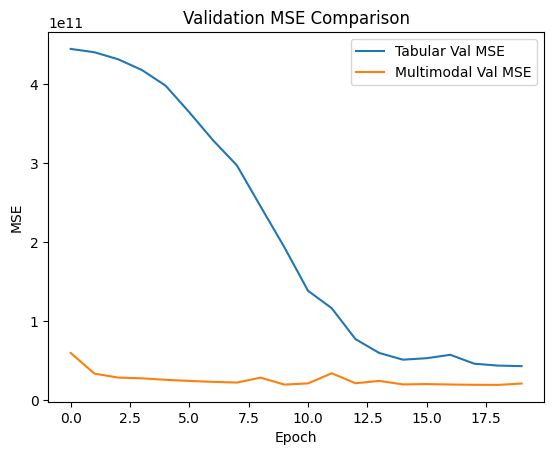

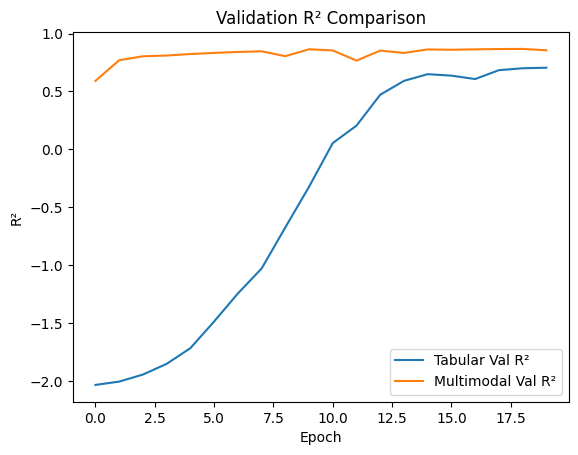

In [7]:
plt.figure()
plt.plot(tab_history['val_loss'], label='Tabular Val MSE')
plt.plot(multi_history['val_loss'], label='Multimodal Val MSE')
plt.title('Validation MSE Comparison')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(tab_history['val_r2'], label='Tabular Val R²')
plt.plot(multi_history['val_r2'], label='Multimodal Val R²')
plt.title('Validation R² Comparison')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.legend()
plt.show()


In [8]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class TestDataset(Dataset):
    def __init__(self, x_path, meta_path, transform=None):
        self.X = pd.read_csv(x_path).values.astype(np.float32)
        self.meta = pd.read_csv(meta_path)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.meta.iloc[idx]['image_path']
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except:
            image = torch.zeros((3, 224, 224))  # fallback

        return image, torch.tensor(self.X[idx])

multi_model.to(DEVICE)
multi_model.eval()

test_ds = TestDataset(
    f"{DATA_DIR}/X_test.csv",
    f"{DATA_DIR}/meta_test.csv",
    transform=transform
)

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


preds = []

print("Generating predictions...")
with torch.no_grad():
    for imgs, tabs in tqdm(test_loader):
        imgs, tabs = imgs.to(DEVICE), tabs.to(DEVICE)
        outputs = multi_model(imgs, tabs)
        preds.extend(outputs.squeeze().cpu().numpy())


meta_test = pd.read_csv(f"{DATA_DIR}/meta_test.csv")

sub = pd.DataFrame({
    'id': meta_test['id'],
    'predicted_price': preds
})

sub.to_csv("submission.csv", index=False)
print("Done! Check submission.csv")


Generating predictions...


100%|██████████| 169/169 [02:32<00:00,  1.11it/s]

Done! Check submission.csv


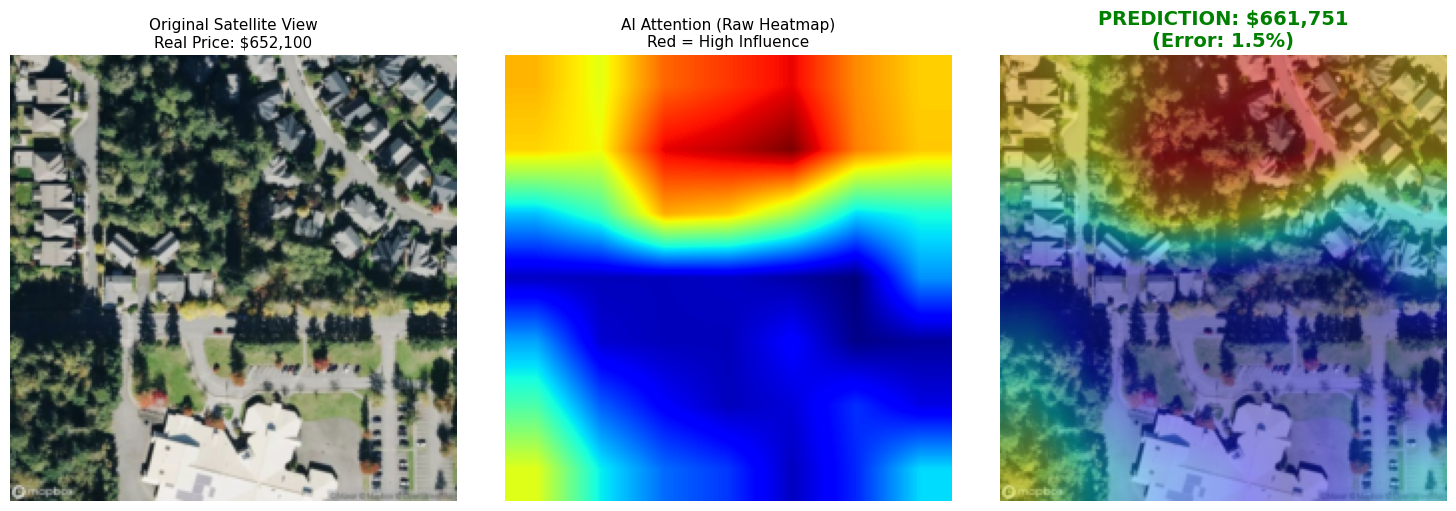

Hooks removed successfully.


In [23]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ==========================================
# 1. GRAD-CAM CLASS
# ==========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        self.handles = []
        
        # Register hooks to capture data during forward/backward passes
        self.handles.append(target_layer.register_forward_hook(self.save_activation))
        self.handles.append(target_layer.register_backward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()

    def generate_cam(self, img_tensor, tab_tensor):
        # 1. Forward Pass
        self.model.eval()
        # We need gradients even though we are in eval mode
        with torch.enable_grad():
            output = self.model(img_tensor.unsqueeze(0), tab_tensor.unsqueeze(0))
            
            # 2. Backward Pass (Targeting the prediction score)
            self.model.zero_grad()
            output.backward()
            
            # Get the prediction value for display later
            predicted_price = output.item()

        # 3. Get captured data
        # Gradients shape: [1, 512, 7, 7] -> [512, 7, 7]
        gradients = self.gradients.data.cpu().numpy()[0]
        # Activations shape: [1, 512, 7, 7] -> [512, 7, 7]
        activations = self.activations.data.cpu().numpy()[0]
        
        # 4. Global Average Pooling of Gradients (Weights)
        # We average the gradients spatially to see which "feature channels" are important
        weights = np.mean(gradients, axis=(1, 2))
        
        # 5. Weighted Combination of Activations
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]
            
        # 6. ReLU (Rectified Linear Unit)
        # We only care about pixels that had a POSITIVE influence on price
        cam = np.maximum(cam, 0)
        
        # 7. Resize heatmap to match original image size (224x224)
        cam = cv2.resize(cam, (224, 224))
        
        # 8. Normalize between 0 and 1 for visualization
        if np.max(cam) > 0:
            cam = (cam - np.min(cam)) / np.max(cam)
        else:
            cam = cam # Prevent divide by zero if cam is empty
            
        return cam, predicted_price

# ==========================================
# 2. VISUALIZATION UTILS
# ==========================================
def denormalize_image(tensor):
    """
    Reverses the ImageNet normalization so the photo looks natural.
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = tensor.cpu().permute(1, 2, 0).numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# ==========================================
# 3. RUN VISUALIZATION
# ==========================================

# A. Select the Target Layer
# In ResNet18, 'layer4' (index 7 in the Sequential children) is the last conv layer
# This is where the semantic features are strongest.
target_layer = multi_model.image_extractor[7]

# B. Initialize GradCAM
grad_cam = GradCAM(multi_model, target_layer)

try:
    # C. Pick a Random Sample from Validation Set
    idx = np.random.randint(0, len(val_ds)) # OR choose a specific index
    img_tensor, tab_tensor, real_price = val_ds[idx]
    img_tensor, tab_tensor = img_tensor.to(DEVICE), tab_tensor.to(DEVICE)

    # D. Generate Heatmap & Prediction
    heatmap, pred_price = grad_cam.generate_cam(img_tensor, tab_tensor)
    
    # E. Calculate Error Percentage
    real_price_val = real_price.item()
    error_val = abs(pred_price - real_price_val)
    error_pct = (error_val / real_price_val) * 100
    
    # F. Prepare Plotting
    original_img = denormalize_image(img_tensor)
    
    # Create the heatmap overlay
    # Convert grayscale heatmap to Jet colormap (Blue=Low, Red=High)
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = np.float32(heatmap_colored) / 255
    
    # Superimpose: 60% Original + 40% Heatmap
    overlay = 0.6 * original_img + 0.4 * heatmap_colored
    overlay = np.clip(overlay, 0, 1)

    # G. Plot Results
    plt.figure(figsize=(15, 5))

    # Plot 1: Original
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title(f"Original Satellite View\nReal Price: ${real_price_val:,.0f}", fontsize=11)
    plt.axis('off')

    # Plot 2: Heatmap Only
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("AI Attention (Raw Heatmap)\nRed = High Influence", fontsize=11)
    plt.axis('off')

    # Plot 3: Overlay with Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    
    # Dynamic Title Color (Green if good prediction, Red if bad)
    title_color = 'green' if error_pct < 15 else 'red'
    
    plt.title(f"PREDICTION: ${pred_price:,.0f}\n(Error: {error_pct:.1f}%)", 
              fontsize=14, fontweight='bold', color=title_color)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

finally:
    # H. Cleanup (IMPORTANT)
    # Always remove hooks to prevent crashes if you run the cell again
    grad_cam.remove_hooks()
    print("Hooks removed successfully.")